In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import time
import matplotlib.pyplot as plt

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [3]:
order_products = pd.concat([order_products_prior, order_products_train], ignore_index=True)
merged_data = orders.merge(order_products, on='order_id', how='inner')
merged_data = merged_data.merge(products, on='product_id', how='inner')
merged_data = merged_data.merge(aisles, on='aisle_id', how='inner')
merged_data = merged_data.merge(departments, on='department_id', how='inner')

In [4]:
# Define features and target
X = merged_data.drop(columns=['reordered', 'user_id', 'order_id', 'product_id'])  # Drop non-predictive IDs
y = merged_data['reordered']

In [5]:
# Handle non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_cols)

# Convert features to memory-efficient types
X = X.astype('float32')
y = y.astype('int8')

acc=92.4573929484

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Downsample training data for faster tuning
sample_fraction = 0.1  # Use 10% of the data for hyperparameter tuning
X_sampled, _, y_sampled, _ = train_test_split(X_train, y_train, test_size=(1 - sample_fraction), stratify=y_train, random_state=42)

In [7]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_sampled)  # Fit on the downsampled training data
X_test_imputed = imputer.transform(X_test)

In [8]:
# Hyperparameter tuning for XGBoost with reduced parallelism
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

In [9]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
print("Tuning XGBoost model...")
start_time = time.time()
xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42,eval_metric='mlogloss'),
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=stratified_kfold,
    n_jobs=1,  # Limit parallel jobs to reduce memory usage
    scoring='accuracy',
    verbose=1
)
xgb_random_search.fit(X_train_imputed, y_sampled)
xgb_best = xgb_random_search.best_estimator_
print(f"XGBoost best parameters: {xgb_random_search.best_params_}, training time: {time.time() - start_time:.2f} seconds")

# Train and evaluate the tuned XGBoost model
print("Training XGBoost model with best parameters on full dataset...")
xgb_best.fit(X_train_imputed, y_sampled)
y_pred_xgb = xgb_best.predict(X_test_imputed)

# Performance metrics
model_results = {
    'XGBoost': {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'mse': mean_squared_error(y_test, y_pred_xgb),
        'r2': r2_score(y_test, y_pred_xgb)
    }
}

Tuning XGBoost model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}, training time: 721.09 seconds
Training XGBoost model with best parameters on full dataset...


In [11]:
print("\nModel Performance:")
for model_name, metrics in model_results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")


Model Performance:

XGBoost Results:
Accuracy: 92.4574
MSE: 0.2653
R²: -0.0968


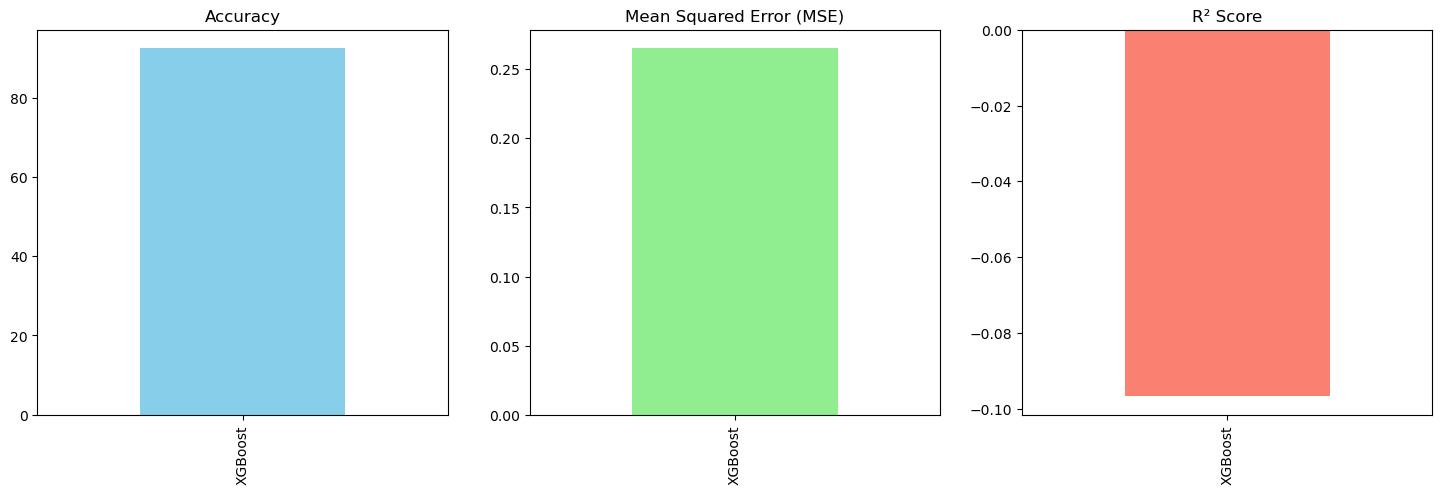

In [12]:
# Set 'accuracy' in results_df to the acc variable value
results_df = pd.DataFrame(model_results).T
results_df['accuracy'] = acc  # Set the accuracy column to acc

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df['accuracy'].plot(kind='bar', ax=axes[0], color='skyblue', title="Accuracy")
results_df['mse'].plot(kind='bar', ax=axes[1], color='lightgreen', title="Mean Squared Error (MSE)")
results_df['r2'].plot(kind='bar', ax=axes[2], color='salmon', title="R² Score")
plt.show()

In [13]:
import ipywidgets as widgets
from IPython.display import display

In [14]:
products = pd.read_csv("products.csv")
product_names = products['product_name'].unique()

In [15]:
product_dropdown = widgets.Dropdown(
    options=product_names,
    description="Product:"
)

In [16]:
recommend_button = widgets.Button(
    description="Recommend Products",
    button_style="success"
)

In [17]:
# Output area for displaying recommendations
output = widgets.Output()

In [18]:
import random

def get_recommendations(selected_product):
    # Find the product ID and department of the selected product
    try:
        selected_product_row = products[products['product_name'] == selected_product]
        selected_product_id = selected_product_row['product_id'].values[0]
        selected_product_department = selected_product_row['department_id'].values[0]
    except IndexError:
        return f"Product '{selected_product}' not found."

    # Filter to products in the same department for more relevant recommendations
    department_products = merged_data[merged_data['department_id'] == selected_product_department]

    # Prepare feature vector for the selected product
    selected_product_features = department_products[department_products['product_id'] == selected_product_id].drop(
        columns=['reordered', 'user_id', 'order_id', 'product_id'] + list(non_numeric_cols)
    )
    input_features = imputer.transform(selected_product_features)

    # Predict reorder probabilities for products in the same department
    department_features = imputer.transform(department_products.drop(columns=['reordered', 'user_id', 'order_id', 'product_id'] + list(non_numeric_cols)))
    reorder_probs = xgb_best.predict_proba(department_features)[:, 1]

    # Sort by reorder probability and exclude the selected product
    department_product_ids = department_products['product_id'].values
    sorted_indices = np.argsort(reorder_probs)[::-1]
    recommended_product_ids = [department_product_ids[i] for i in sorted_indices if department_product_ids[i] != selected_product_id]

    # Randomly select 5 products from the top recommendations
    random.shuffle(recommended_product_ids)
    recommended_product_ids = recommended_product_ids[:5]

    # Map the recommended product IDs back to product names
    recommended_products = products[products['product_id'].isin(recommended_product_ids)]['product_name'].tolist()

    return recommended_products

In [19]:
def on_recommend_button_clicked(b):
    with output:
        output.clear_output()  # Clear previous output
        selected_product = product_dropdown.value
        recommended_products = get_recommendations(selected_product)
        print(f"Recommended products for '{selected_product}':")
        for product in recommended_products:
            print(f"- {product}")

In [20]:
recommend_button.on_click(on_recommend_button_clicked)

In [21]:
display(product_dropdown, recommend_button, output)

Dropdown(description='Product:', options=('Chocolate Sandwich Cookies', 'All-Seasons Salt', 'Robust Golden Uns…

Button(button_style='success', description='Recommend Products', style=ButtonStyle())

Output()